In [1]:
#Riley Estes
#5/15/2023
#EE 399 HW 5
#Github:
#https://github.com/rileywe/Lorenz-Equations-with-NN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Set Lorentz parameters and equations
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
  x, y, z = x_y_z
  return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [4]:
# Generate training data for a given rho value
def generate_data(rho=rho, sigma=sigma, beta=beta, t=t, dt=dt):
  np.random.seed(123)
  x0 = -15 + 30 * np.random.random((100, 3))
  x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(sigma, beta, rho)) for x0_j in x0])
  nn_input = np.zeros((100*(len(t)-2), 6))
  nn_output = np.zeros((100*(len(t)-2), 3))

  for j in range(100):
    for i in range(1, len(t)-1):
      nn_input[j*(len(t)-2)+(i-1), :3] = x_t[j,i-1]
      nn_input[j*(len(t)-2)+(i-1), 3:] = [dt, rho, sigma]
      nn_output[j*(len(t)-2)+(i-1), :] = x_t[j,i]

  return nn_input, nn_output, x0, x_t

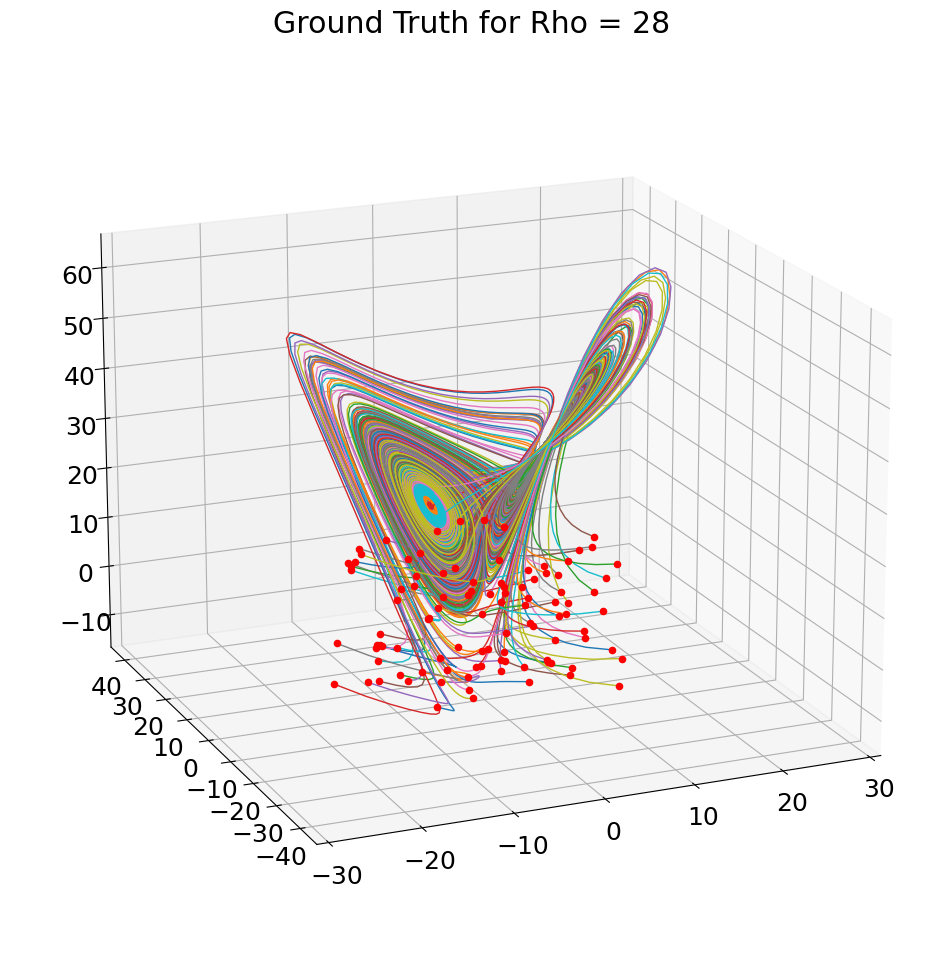

In [10]:
# Plot the Lorentz equation graph with rho = 28
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

nn_input, nn_output, x0, x_t = generate_data()

for j in range(100):    
  x, y, z = x_t[j,:,:].T
  ax.plot(x, y, z,linewidth=1)
  ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

plt.title(f"Ground Truth for Rho = {rho}")
ax.set_xlim([-30, 30])
ax.set_ylim([-45, 45])
ax.set_zlim([-15, 65])
ax.view_init(18, -113)
plt.show()

In [5]:
# Define activation functions for NN
def logsig(x):
  return 1 / (1 + torch.exp(-x))

def radbas(x):
  return torch.exp(-torch.pow(x, 2))

def purelin(x):
  return x

# Define the model
class LorenzModel(nn.Module):
  def __init__(self):
    super(LorenzModel, self).__init__()
    self.fc1 = nn.Linear(6, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 3)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Create feed-forward neural network model that will predict the output of the Lorentz equations at time + 1
model = LorenzModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Train NN model on 3 new rho values
# Trains consecutively using the weights from the last rho value for the next one
rho_values_train = [10, 28, 40]
model.train()

for rho_train in rho_values_train:

  print("Training with rho = {}".format(rho_train))

  nn_input, nn_output, x0, x_t = generate_data(rho=rho_train)
  
  # Convert data to tensors
  nn_input_tensor = torch.from_numpy(nn_input).float()
  nn_output_tensor = torch.from_numpy(nn_output).float()

  print("Feed-forward neural network: ")
  # Train the model
  for epoch in range(30):
    optimizer.zero_grad()
    outputs = model(nn_input_tensor)
    loss = criterion(outputs, nn_output_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")
  
  print()

Training with rho = 10
Feed-forward neural network: 
Epoch 1, loss = 48.6110
Epoch 2, loss = 43.0603
Epoch 3, loss = 37.8501
Epoch 4, loss = 33.0808
Epoch 5, loss = 28.7265
Epoch 6, loss = 24.8836
Epoch 7, loss = 21.5049
Epoch 8, loss = 18.5002
Epoch 9, loss = 15.8683
Epoch 10, loss = 13.5943
Epoch 11, loss = 11.6885
Epoch 12, loss = 10.1367
Epoch 13, loss = 8.8935
Epoch 14, loss = 7.9070
Epoch 15, loss = 7.1296
Epoch 16, loss = 6.5046
Epoch 17, loss = 5.9350
Epoch 18, loss = 5.3719
Epoch 19, loss = 4.7858
Epoch 20, loss = 4.1688
Epoch 21, loss = 3.5309
Epoch 22, loss = 2.9065
Epoch 23, loss = 2.3384
Epoch 24, loss = 1.8546
Epoch 25, loss = 1.4818
Epoch 26, loss = 1.2322
Epoch 27, loss = 1.1039
Epoch 28, loss = 1.0817
Epoch 29, loss = 1.1402
Epoch 30, loss = 1.2466

Training with rho = 28
Feed-forward neural network: 
Epoch 1, loss = 24.8566
Epoch 2, loss = 20.5798
Epoch 3, loss = 14.8003
Epoch 4, loss = 9.5897
Epoch 5, loss = 6.3734
Epoch 6, loss = 5.8178
Epoch 7, loss = 7.4086
Epoch 

In [6]:
outputs.shape
nn_output.shape

(79900, 3)

In [6]:
def plot_preds (predicted, t, x0, title):
  # Plot the predicted 3D graph
  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(111, projection='3d')
  for j in range(100):
    ax.plot(predicted[j*(len(t)-2):(j+1)*(len(t)-2),0],
            predicted[j*(len(t)-2):(j+1)*(len(t)-2),1],
            predicted[j*(len(t)-2):(j+1)*(len(t)-2),2],linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

  ax.set_xlim([-30, 30])
  ax.set_ylim([-45, 45])
  ax.set_zlim([-15, 65])
  ax.view_init(18, -113)
  plt.title(title)
  plt.show()

For rho = 17, Loss = 2.9199


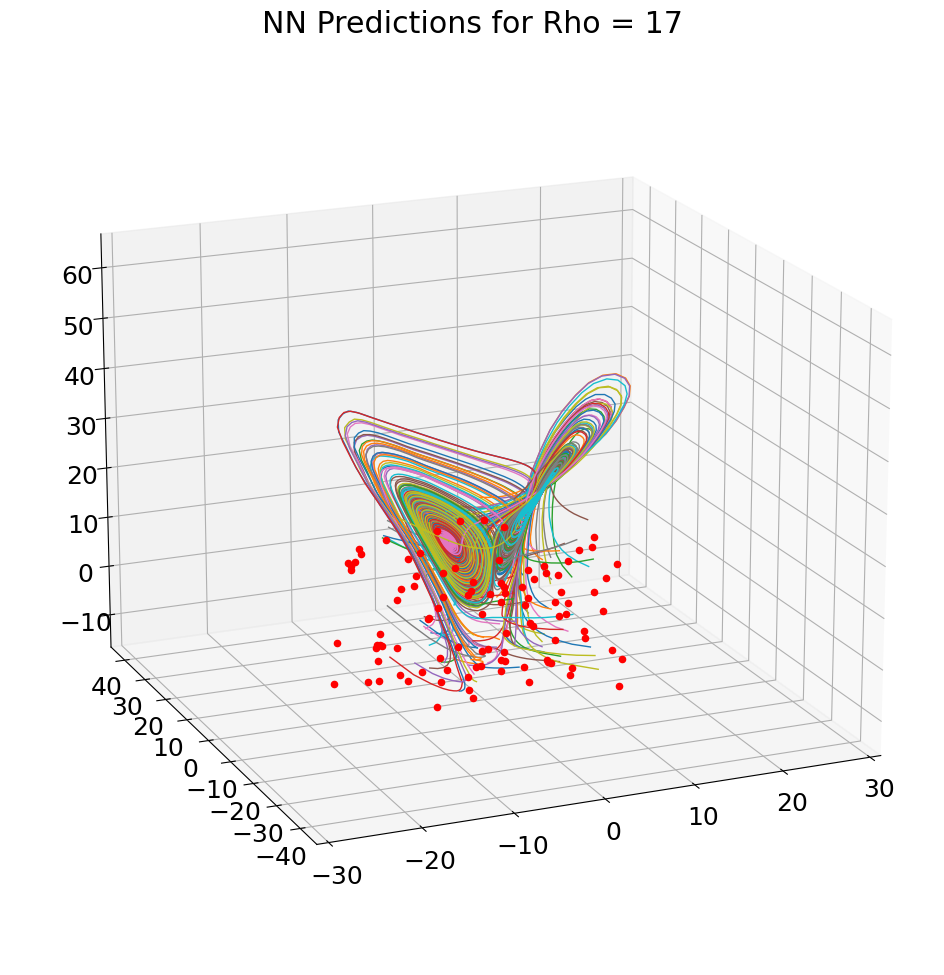

For rho = 35, Loss = 0.3690


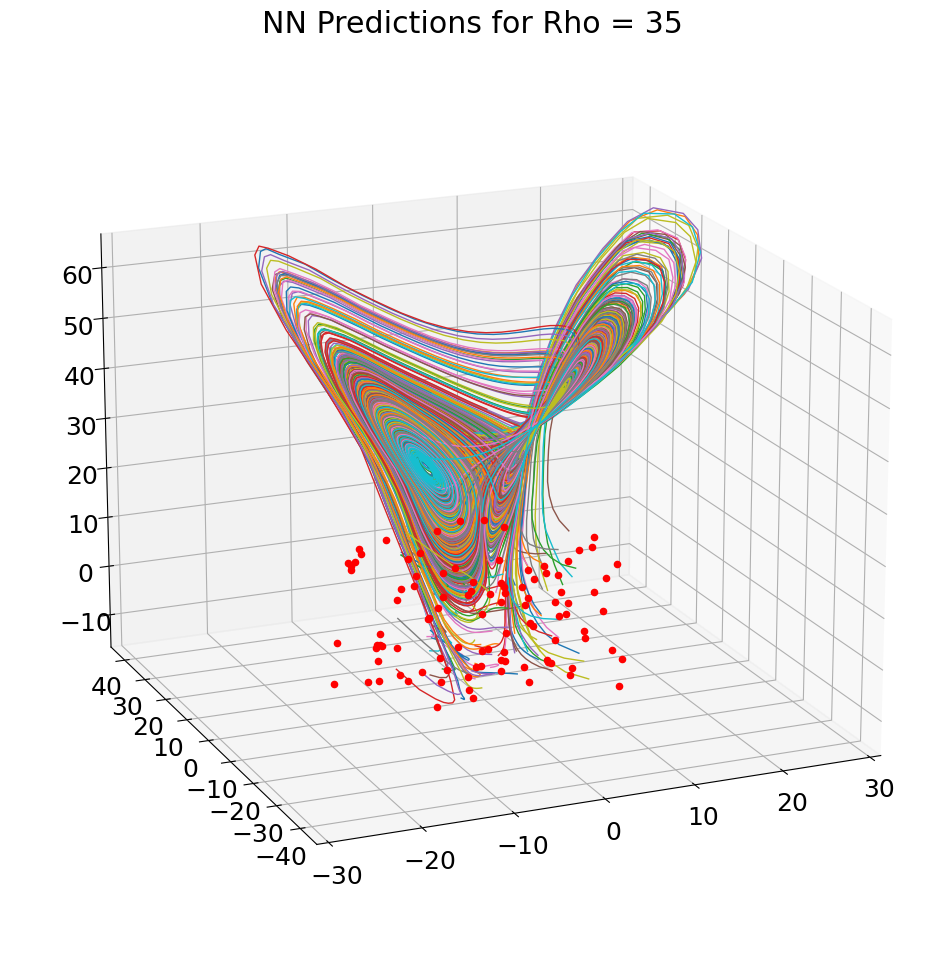

In [10]:
# Tests the NN on two new rho values
rho_values_test = [17, 35]
model.eval()

for rho_test in rho_values_test:

  nn_input, nn_output, x0, x_t = generate_data(rho=rho_test)

  # Convert data to tensors
  nn_input_tensor = torch.tensor(nn_input, dtype=torch.float32)
  nn_output_tensor = torch.tensor(nn_output, dtype=torch.float32)

  # Evaluate the loss
  predictions = model(nn_input_tensor)
  loss = criterion(predictions, nn_output_tensor)
  print(f"For rho = {rho_test}, Loss = {loss.item():.4f}")

  plot_preds(predictions.detach().numpy(), t, x0, f"NN Predictions for Rho = {rho_test}")

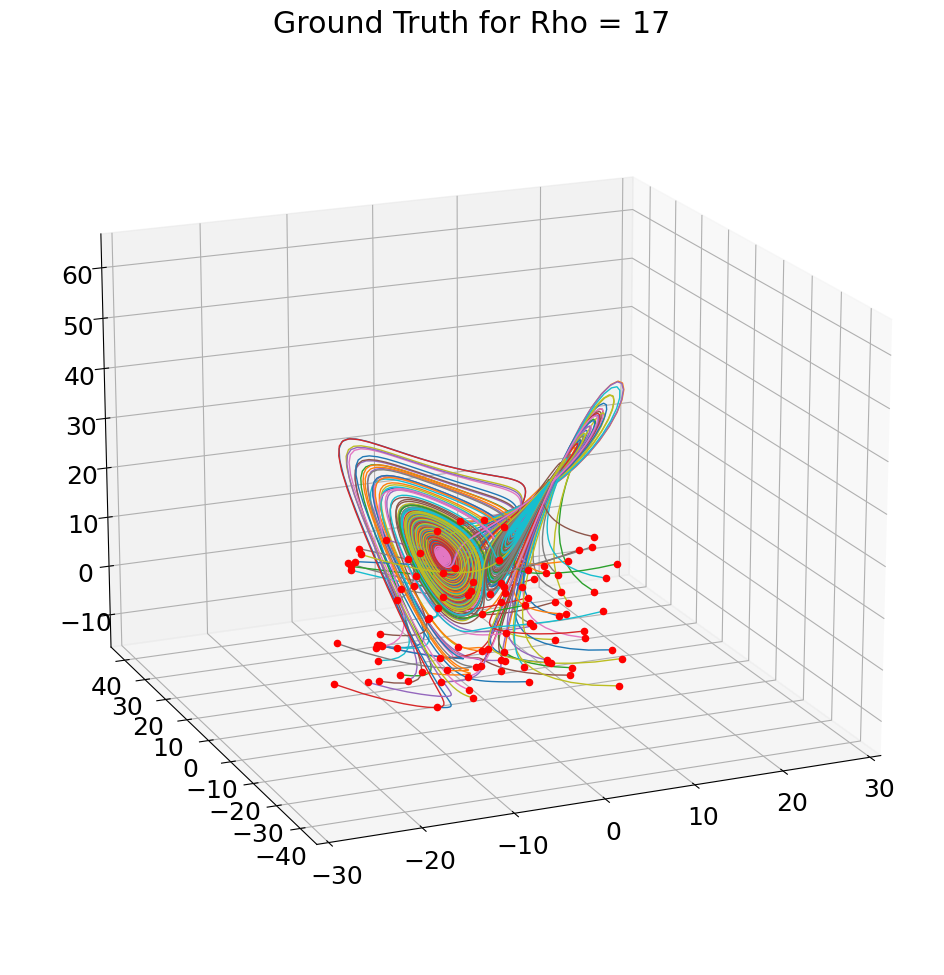

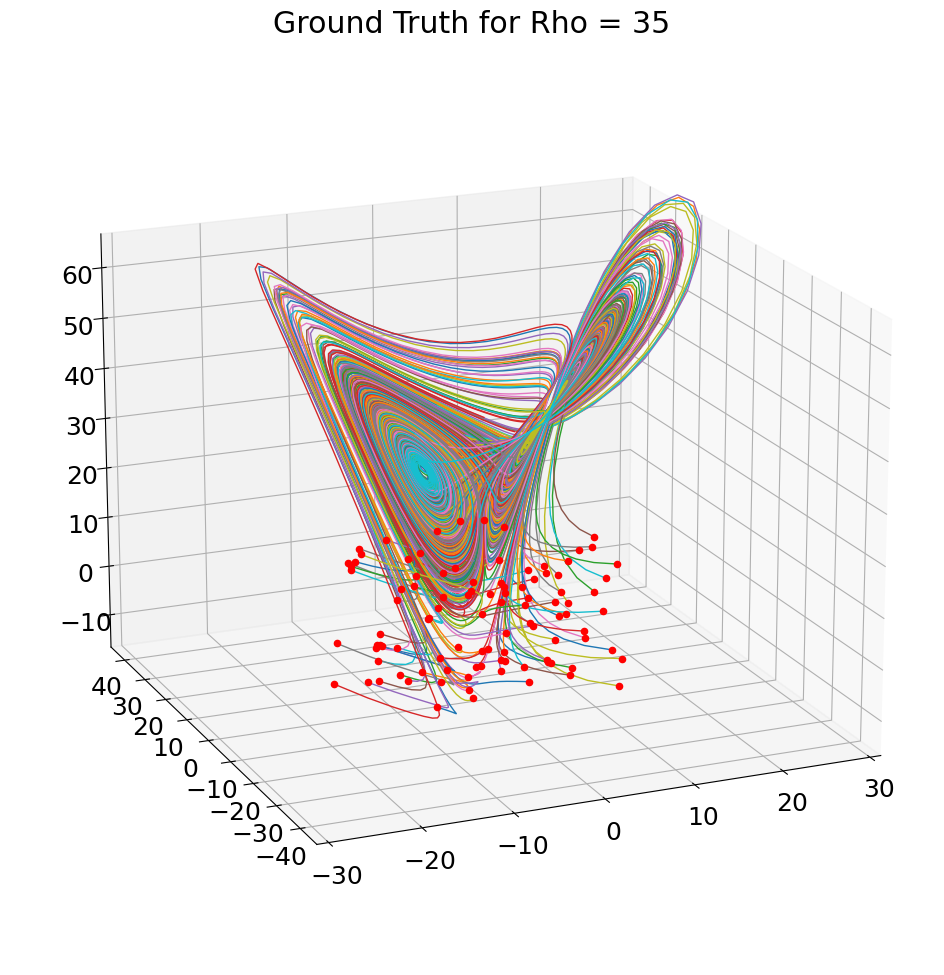

In [9]:
# Plots the ground truth graphs for the two rho values tested on
for rho_test in rho_values_test:
  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(111, projection='3d')

  nn_input, nn_output, x0, x_t = generate_data(rho=rho_test)

  for j in range(100):
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

  plt.title(f"Ground Truth for Rho = {rho_test}")
  ax.set_xlim([-30, 30])
  ax.set_ylim([-45, 45])
  ax.set_zlim([-15, 65])
  ax.view_init(18, -113)
  plt.show()

In [7]:
# Define LSTM model
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
        
  def forward(self, x):
    output, _ = self.lstm(x)
    output = output.squeeze(1)
    output = self.fc(output)
    return output

# Define RNN model
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNNModel, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
        
  def forward(self, x):
    output, _ = self.rnn(x)
    output = output.squeeze(1)
    output = self.fc(output)
    return output

# Define Echo State Network model
class ESNModel(nn.Module):
  def __init__(self, input_size, reservoir_size, output_size):
    super(ESNModel, self).__init__()
    self.reservoir = nn.Linear(input_size + reservoir_size, reservoir_size)
    self.output = nn.Linear(reservoir_size, output_size)

  def forward(self, x, reservoir_state):
    input_reservoir = torch.cat((x, reservoir_state), dim=1)
    reservoir_state = torch.tanh(self.reservoir(input_reservoir))
    output = self.output(reservoir_state)
    return output, reservoir_state

In [8]:
# Set model parameters
hidden_size = 128
batch_size = 32
num_epochs = 30

In [14]:
lstm_model = LSTMModel(input_size=6, hidden_size=hidden_size, output_size=3)
criterion = nn.MSELoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
lstm_model.train()

# Training loop
for rho_train in rho_values_train:
  nn_input, nn_output, x0, x_t = generate_data(rho_train)
  nn_input_tensor = torch.from_numpy(nn_input).float()
  nn_output_tensor = torch.from_numpy(nn_output).float()
  print("Rho value = {}".format(rho_train))

  # Training loop for LSTM model
  print("LSTM: ")
  for epoch in range(num_epochs):
    optimizer_lstm.zero_grad()
    outputs = lstm_model(nn_input_tensor)
    loss = criterion(outputs, nn_output_tensor)
    loss.backward()
    optimizer_lstm.step()
    print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")
  print()


Rho value = 10
LSTM: 
Epoch 1, loss = 42.8274
Epoch 2, loss = 41.4627
Epoch 3, loss = 40.1400
Epoch 4, loss = 38.8590
Epoch 5, loss = 37.6173
Epoch 6, loss = 36.4074
Epoch 7, loss = 35.2191
Epoch 8, loss = 34.0428
Epoch 9, loss = 32.8719
Epoch 10, loss = 31.7023
Epoch 11, loss = 30.5287
Epoch 12, loss = 29.3464
Epoch 13, loss = 28.1561
Epoch 14, loss = 26.9651
Epoch 15, loss = 25.7853
Epoch 16, loss = 24.6299
Epoch 17, loss = 23.5087
Epoch 18, loss = 22.4270
Epoch 19, loss = 21.3866
Epoch 20, loss = 20.3882
Epoch 21, loss = 19.4306
Epoch 22, loss = 18.5103
Epoch 23, loss = 17.6237
Epoch 24, loss = 16.7681
Epoch 25, loss = 15.9426
Epoch 26, loss = 15.1479
Epoch 27, loss = 14.3861
Epoch 28, loss = 13.6601
Epoch 29, loss = 12.9691
Epoch 30, loss = 12.3115

Rho value = 28
LSTM: 
Epoch 1, loss = 187.7010
Epoch 2, loss = 184.6361
Epoch 3, loss = 181.3011
Epoch 4, loss = 177.9334
Epoch 5, loss = 174.4891
Epoch 6, loss = 170.9763
Epoch 7, loss = 167.4582
Epoch 8, loss = 164.1835
Epoch 9, loss 

In [13]:
rnn_model = RNNModel(input_size=6, hidden_size=hidden_size, output_size=3)
criterion = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
rnn_model.train()

for rho_train in rho_values_train:
  nn_input, nn_output, x0, x_t = generate_data(rho_train)
  nn_input_tensor = torch.from_numpy(nn_input).float()
  nn_output_tensor = torch.from_numpy(nn_output).float()

  train_dataset = TensorDataset(nn_input_tensor, nn_output_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  print("Rho value = {}".format(rho_train))
  
  # Training loop for RNN model
  print("RNN: ")
  for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, targets in train_loader:
      optimizer_rnn.zero_grad()
      outputs = rnn_model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer_rnn.step()
      epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, loss = {epoch_loss:.4f}")
  print()


Rho value = 10
RNN: 
Epoch 1, loss = 3390.5773
Epoch 2, loss = 318.9815
Epoch 3, loss = 199.1208
Epoch 4, loss = 145.1687
Epoch 5, loss = 129.5268
Epoch 6, loss = 116.4374
Epoch 7, loss = 97.3130
Epoch 8, loss = 103.4296
Epoch 9, loss = 70.7672
Epoch 10, loss = 81.5149
Epoch 11, loss = 63.7842
Epoch 12, loss = 61.1106
Epoch 13, loss = 51.1185
Epoch 14, loss = 59.6531
Epoch 15, loss = 63.4662
Epoch 16, loss = 59.7478
Epoch 17, loss = 46.6380
Epoch 18, loss = 51.7168
Epoch 19, loss = 41.2538
Epoch 20, loss = 37.7067
Epoch 21, loss = 46.8981
Epoch 22, loss = 37.5264
Epoch 23, loss = 36.2460
Epoch 24, loss = 36.2369
Epoch 25, loss = 34.0983
Epoch 26, loss = 34.3227
Epoch 27, loss = 37.9958
Epoch 28, loss = 37.0197
Epoch 29, loss = 34.4712
Epoch 30, loss = 30.2708

Rho value = 28
RNN: 
Epoch 1, loss = 1171.5864
Epoch 2, loss = 208.9666
Epoch 3, loss = 155.3014
Epoch 4, loss = 157.8554
Epoch 5, loss = 135.3257
Epoch 6, loss = 129.7351
Epoch 7, loss = 133.7696
Epoch 8, loss = 116.6471
Epoch 9

In [16]:
esn_model = ESNModel(input_size=6, reservoir_size=hidden_size, output_size=3)
criterion = nn.MSELoss()
optimizer_esn = torch.optim.Adam(esn_model.parameters(), lr=0.001)
esn_model.train()

for rho_train in rho_values_train:
  nn_input, nn_output, x0, x_t = generate_data(rho_train)
  nn_input_tensor = torch.from_numpy(nn_input).float()
  nn_output_tensor = torch.from_numpy(nn_output).float()
  print("Rho value = {}".format(rho_train))
    
  # Training loop for Echo State Network model
  print("Echo State Network: ")
  reservoir_state = torch.zeros(nn_input_tensor.size(0), hidden_size)
  for epoch in range(num_epochs):
    optimizer_esn.zero_grad()
    outputs, reservoir_state = esn_model(nn_input_tensor, reservoir_state.detach())
    loss = criterion(outputs, nn_output_tensor)
    loss.backward()
    optimizer_esn.step()
    print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")

Rho value = 10
Echo State Network: 
Epoch 1, loss = 45.7301
Epoch 2, loss = 44.5790
Epoch 3, loss = 42.3821
Epoch 4, loss = 40.2576
Epoch 5, loss = 38.0462
Epoch 6, loss = 35.9388
Epoch 7, loss = 33.9729
Epoch 8, loss = 32.1409
Epoch 9, loss = 30.4438
Epoch 10, loss = 28.8771
Epoch 11, loss = 27.4294
Epoch 12, loss = 26.0890
Epoch 13, loss = 24.8444
Epoch 14, loss = 23.6844
Epoch 15, loss = 22.5992
Epoch 16, loss = 21.5801
Epoch 17, loss = 20.6198
Epoch 18, loss = 19.7117
Epoch 19, loss = 18.8505
Epoch 20, loss = 18.0315
Epoch 21, loss = 17.2507
Epoch 22, loss = 16.5049
Epoch 23, loss = 15.7913
Epoch 24, loss = 15.1078
Epoch 25, loss = 14.4525
Epoch 26, loss = 13.8244
Epoch 27, loss = 13.2226
Epoch 28, loss = 12.6469
Epoch 29, loss = 12.0969
Epoch 30, loss = 11.5724
Rho value = 28
Echo State Network: 
Epoch 1, loss = 206.5290
Epoch 2, loss = 177.5753
Epoch 3, loss = 176.9321
Epoch 4, loss = 173.6541
Epoch 5, loss = 170.8809
Epoch 6, loss = 168.0508
Epoch 7, loss = 165.2687
Epoch 8, los

For rho = 17
LSTM loss = 10.2878
RNN loss = 76.9033
ESN loss = 14.9441


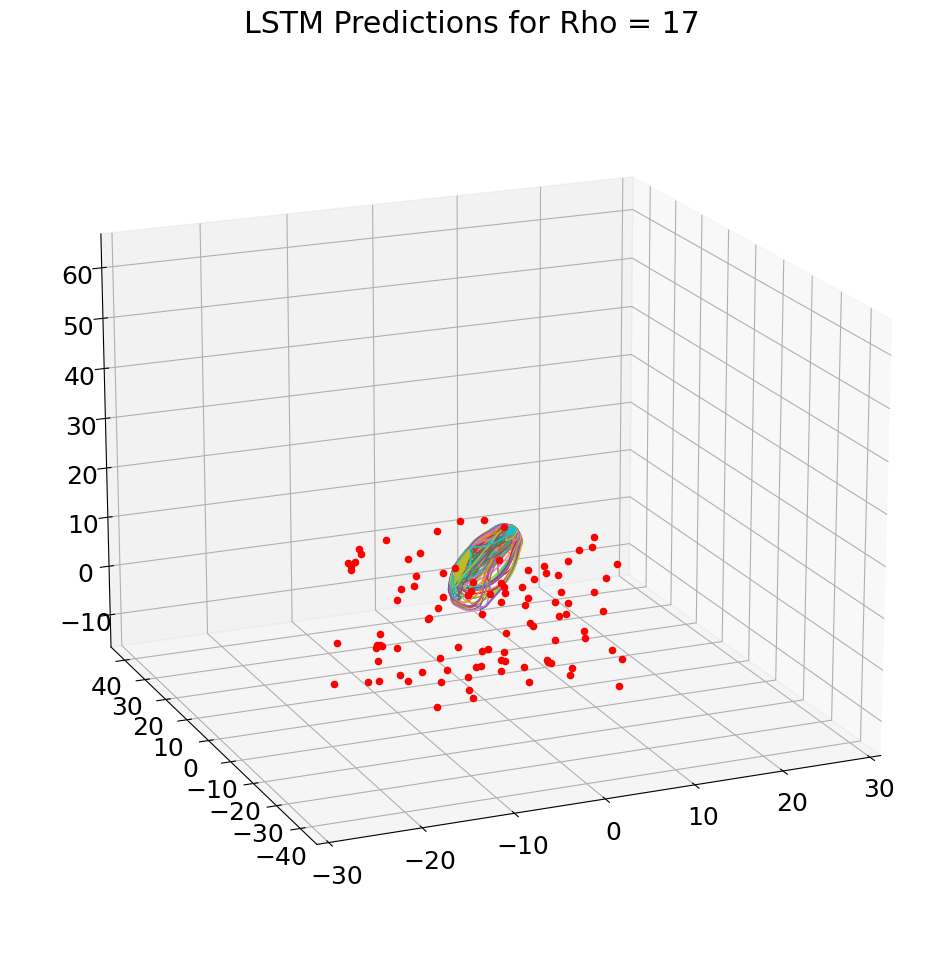

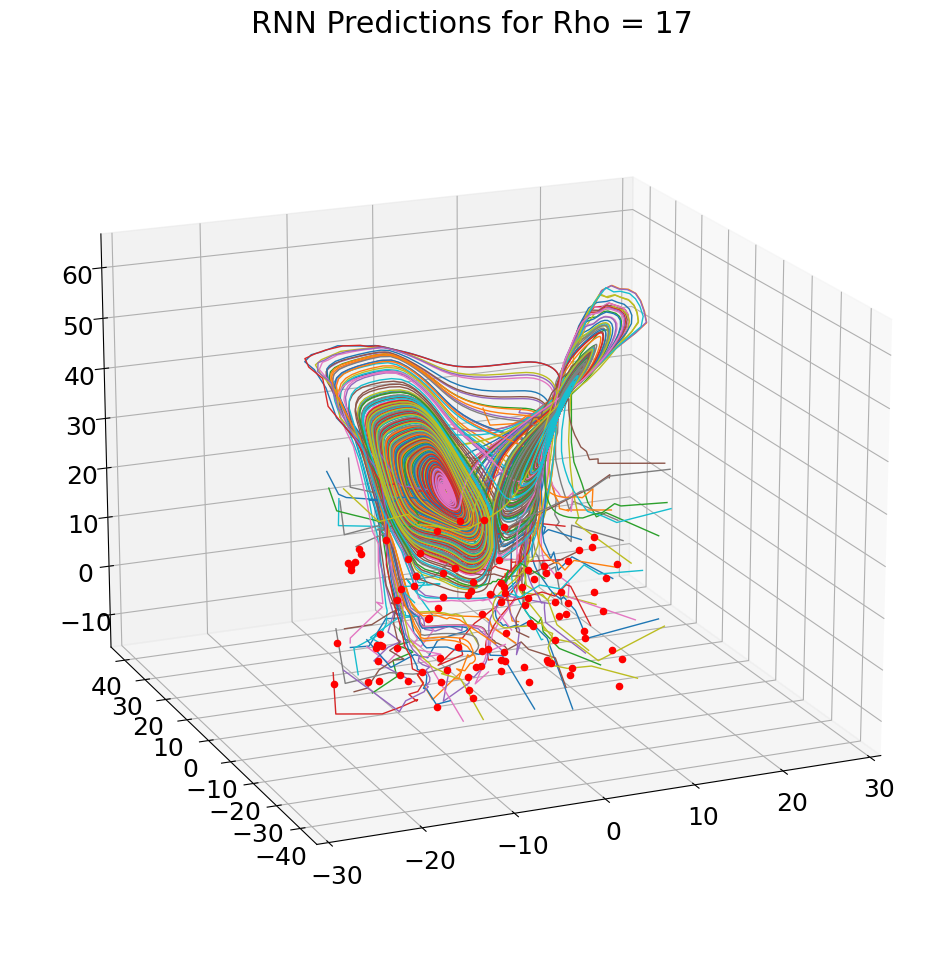

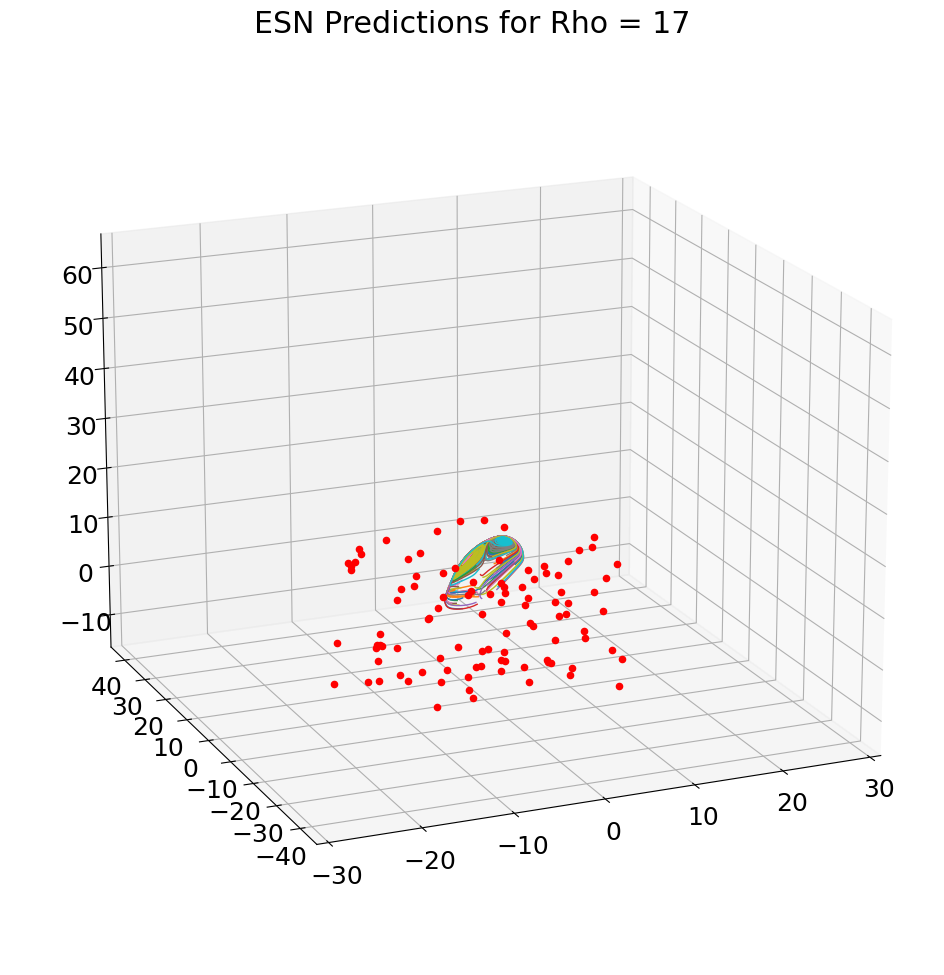

For rho = 35
LSTM loss = 144.1929
RNN loss = 1.9236
ESN loss = 162.2735


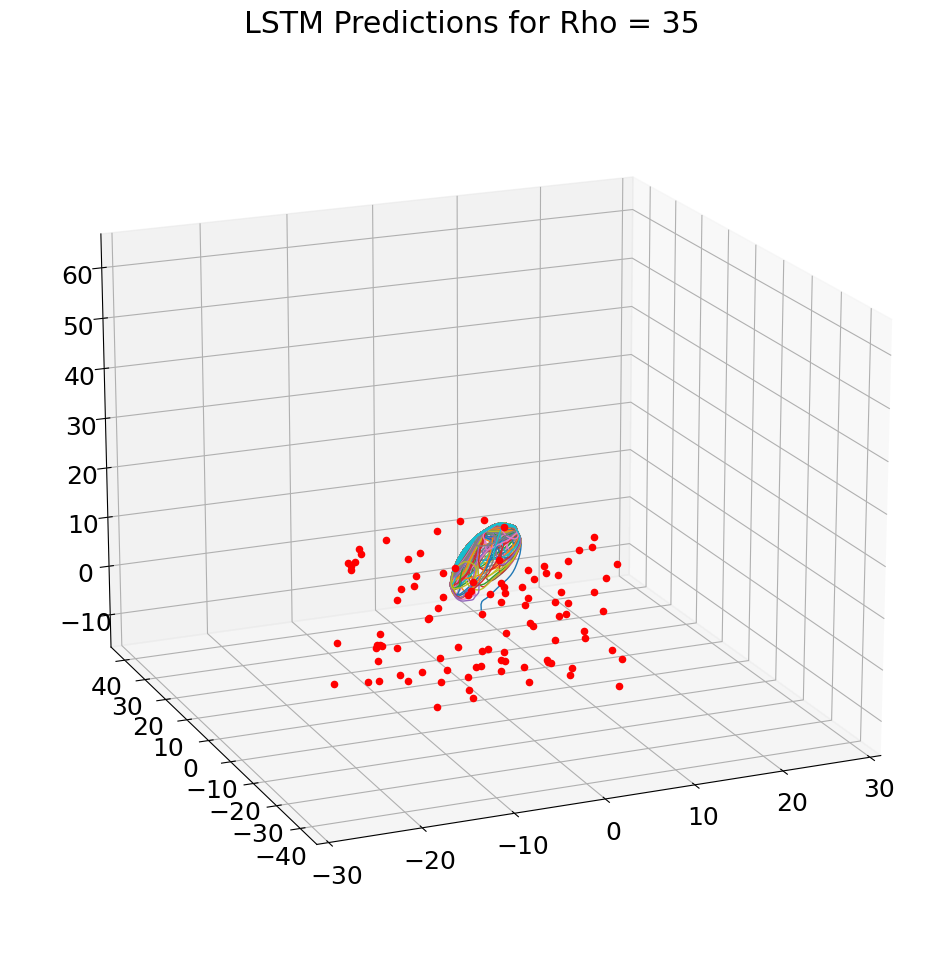

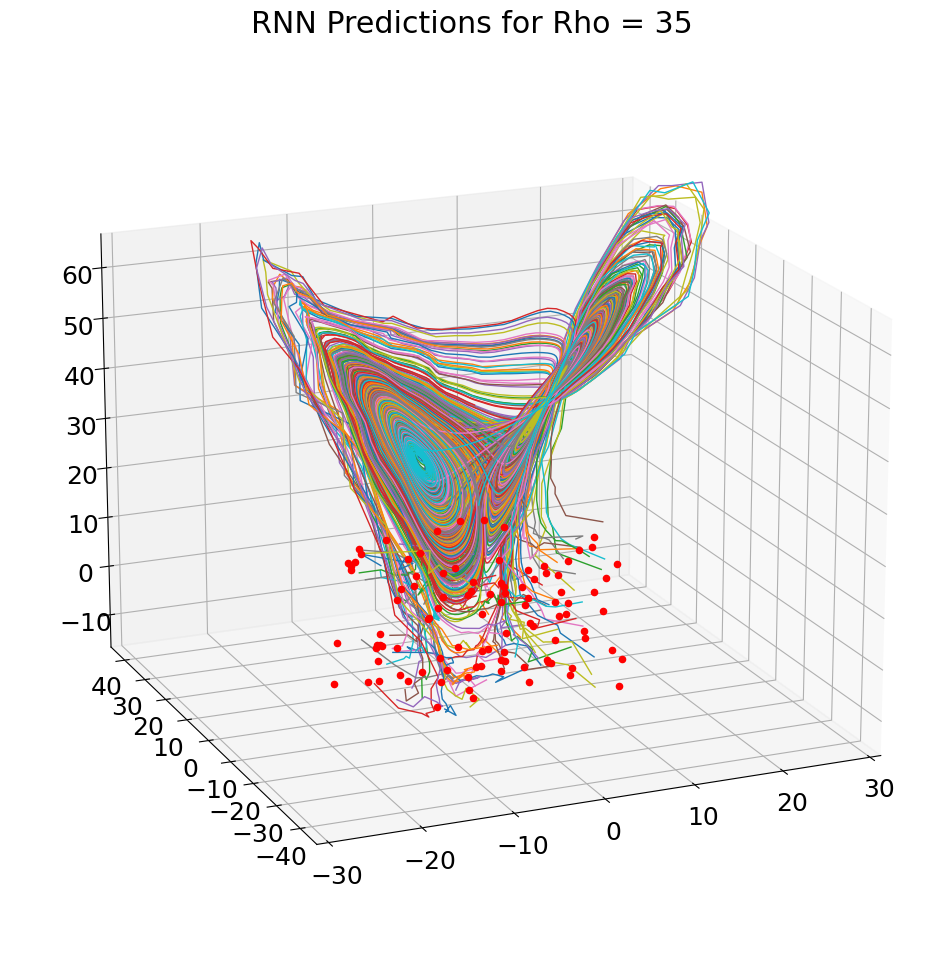

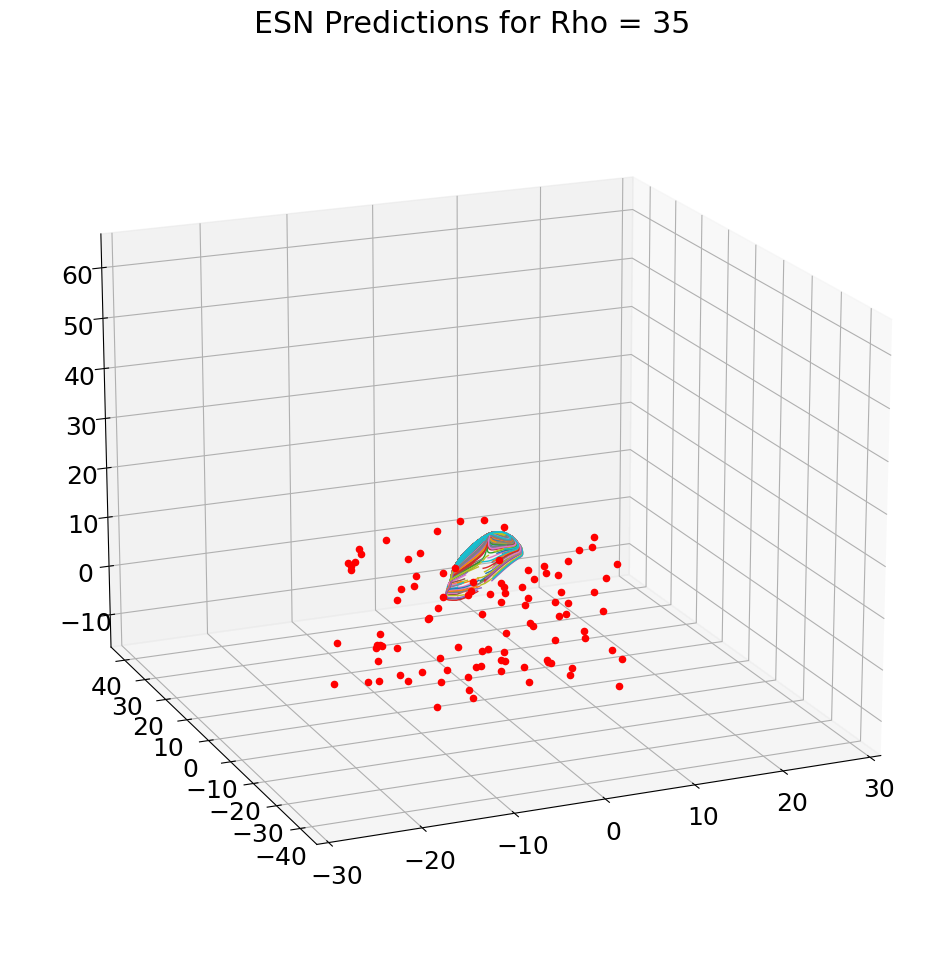

In [16]:
lstm_model.eval()
rnn_model.eval()
esn_model.eval()

# Evaluation for future state prediction
for rho_test in rho_values_test:
  print("For rho = {}".format(rho_test))
  nn_input_test, nn_output_test, x0, x_t = generate_data(rho_test)
  input_test = torch.tensor(nn_input_test, dtype=torch.float32)
  output_test = torch.tensor(nn_output_test, dtype=torch.float32)
        
  # Evaluate LSTM model
  lstm_predictions = lstm_model(input_test)
  lstm_loss = criterion(lstm_predictions, output_test)
  print("LSTM loss = {:.4f}".format(lstm_loss))

  # Evaluate RNN model
  rnn_predictions = rnn_model(input_test)
  rnn_loss = criterion(rnn_predictions, output_test)
  print("RNN loss = {:.4f}".format(rnn_loss))
        
  # Evaluate Echo State Network model
  reservoir_state = torch.zeros(input_test.size(0), hidden_size)
  esn_predictions, _ = esn_model(input_test, reservoir_state)
  esn_loss = criterion(esn_predictions, output_test)
  print("ESN loss = {:.4f}".format(esn_loss))

  plot_preds(lstm_predictions.detach().numpy(), t, x0, f"LSTM Predictions for Rho = {rho_test}")
  plot_preds(rnn_predictions.detach().numpy(), t, x0, f"RNN Predictions for Rho = {rho_test}")
  plot_preds(esn_predictions.detach().numpy(), t, x0, f"ESN Predictions for Rho = {rho_test}")